## load the dataset and create the final using dataset with attribute "Quadrant". 

In [29]:
import os
import pandas as pd
from pathlib import Path

# Your current folder where images are organized by fine-grained types
source_root = Path("image50")  # e.g., "images_by_cell_types"
cbr_path = Path("metadata/metadata_code/cbr.csv")  # adjust path to where your cbr.csv is

# Mapping fine-grained clusters to broader groups
cell_group_map = {
    # Immune
    "CD4+_T_Cells": "Immune",
    "CD8+_T_Cells": "Immune",
    "B_Cells": "Immune",
    "IRF7+_DCs": "Immune",
    "LAMP3+_DCs": "Immune",
    "Macrophages_1": "Immune",
    "Macrophages_2": "Immune",
    "Mast_Cells": "Immune",

    #hybrids
    "Stromal_and_T_Cell_Hybrid": "Hybrid",
    "T_Cell_and_Tumor_Hybrid": "Hybrid",

    # Tumor
    "Prolif_Invasive_Tumor": "Tumor",
    "Invasive_Tumor": "Tumor",

    #early stage cancer
    "DCIS_1": "Early stage cancer",
    "DCIS_2": "Early stage cancer",

    # Connective tissue
    "Stromal": "Connective tissue",
    "Perivascular-Like": "Connective tissue",
    "Myoepi_ACTA2+": "Connective tissue",
    "Myoepi_KRT15+": "Connective tissue",

    #endothelial
    "Endothelial": "Endothelial",

    # Unlabeled
    "Unlabeled": "Unlabeled"
}
# Function to map specific types into Cancer / Non-Cancer
def map_cancer_type(mapped_type):
    if mapped_type in ["Tumor", "Early stage cancer"]:
        return "Cancer"
    elif mapped_type == "Unlabeled":
        return "Unlabeled"
    else:
        return "Non_Cancer"

In [31]:
# Prepare a list for all records
records = []

# Traverse folders
for folder_name in os.listdir(source_root):
    folder_path = source_root / folder_name
    if folder_path.is_dir():
        # Map folder name to specific category
        mapped_specific = cell_group_map.get(folder_name, "Unknown")
        
        if mapped_specific == "Unknown":
            print(f"Warning: Folder {folder_name} not found in cell_group_map. Skipping.")
            continue

        broad_category = map_cancer_type(mapped_specific)

        # Loop through images
        for file_name in os.listdir(folder_path):
            if file_name.endswith((".png", ".jpg", ".jpeg")):
                full_path = f"{folder_path}/{file_name}"

                # Try to extract index from filename (assume number in filename)
                # Example filename: "img_123.png" → index=123
                import re
                match = re.search(r'\d+', file_name)
                img_index = int(match.group()) if match else None

                records.append({
                    "Folder": folder_name,
                    "File Name": file_name,
                    "Path": str(full_path),
                    "Category Type": broad_category,
                    "Specific Category": mapped_specific,
                    "Image Index": img_index
                })

# Create DataFrame
df_image_raw = pd.DataFrame(records)

df_image = df_image_raw[df_image_raw['Category Type'] != "Unlabeled"].reset_index(drop=True)


In [33]:
# Load coordinate information
cbr_df = pd.read_csv(cbr_path)

# Get median axis for quadrant separation
x_median = cbr_df['axis-1'].median()
y_median = cbr_df['axis-0'].median()

# Function to get quadrant
def get_quadrant(row):
    if row['axis-1'] < x_median and row['axis-0'] < y_median:
        return "Q1"  # Top-left
    elif row['axis-1'] >= x_median and row['axis-0'] < y_median:
        return "Q2"  # Top-right
    elif row['axis-1'] < x_median and row['axis-0'] >= y_median:
        return "Q3"  # Bottom-left
    else:
        return "Q4"  # Bottom-right

# Assign quadrant to cbr_df
cbr_df['Quadrant'] = cbr_df.apply(get_quadrant, axis=1)

# Merge image dataframe with coordinate info
df_final = pd.merge(df_image, cbr_df[['index', 'Quadrant']], left_on='Image Index', right_on='index', how='left')

# --- Safety Checks ---

# Check how many images failed to match (missing quadrant)
missing_quadrant = df_final['Quadrant'].isna().sum()

if missing_quadrant > 0:
    print(f"Warning: {missing_quadrant} images could not be matched to any coordinate in cbr.csv!")
    unmatched_images = df_final[df_final['Quadrant'].isna()]
    print(unmatched_images[['File Name', 'Image Index']])

# Drop the extra 'index' column after merge
df_final = df_final.drop(columns=['index'])

# Save final dataset
#df_final.to_csv("used_dataset.csv", index=False)

# Preview
df_final.head()

,Folder,File Name,Path,Category Type,Specific Category,Image Index,Quadrant
0,CD4+_T_Cells,cell_111457_50.png,image50/CD4+_T_Cells/cell_111457_50.png,Non_Cancer,Immune,111457,Q4
1,CD4+_T_Cells,cell_111457_50.png,image50/CD4+_T_Cells/cell_111457_50.png,Non_Cancer,Immune,111457,Q4
2,CD4+_T_Cells,cell_111457_50.png,image50/CD4+_T_Cells/cell_111457_50.png,Non_Cancer,Immune,111457,Q4
3,CD4+_T_Cells,cell_111457_50.png,image50/CD4+_T_Cells/cell_111457_50.png,Non_Cancer,Immune,111457,Q4
4,CD4+_T_Cells,cell_111457_50.png,image50/CD4+_T_Cells/cell_111457_50.png,Non_Cancer,Immune,111457,Q4


In [35]:
df_final.to_csv("used_dataset.csv", index=False)

In [37]:
import numpy as np

# Set random seed
np.random.seed(3888)

# Check category distribution first
print(df_final['Category Type'].value_counts())
print(df_final['Quadrant'].value_counts())

# Separate Cancer and Non_Cancer
cancer_df = df_final[df_final['Category Type'] == "Cancer"]
non_cancer_df = df_final[df_final['Category Type'] == "Non_Cancer"]

# Helper function for stratified sampling per quadrant
def stratified_sample(df, category_name):
    samples = []
    for quadrant in ["Q1", "Q2", "Q3", "Q4"]:
        subset = df[df['Quadrant'] == quadrant]
        if len(subset) < 250:
            print(f"Warning: Only {len(subset)} samples available in {category_name} {quadrant}. Sampling all available.")
            sampled = subset.sample(n=len(subset), random_state=3888)
        else:
            sampled = subset.sample(n=250, random_state=3888)
        samples.append(sampled)
    return pd.concat(samples)

# Stratified sampling
cancer_sample = stratified_sample(cancer_df, "Cancer")
non_cancer_sample = stratified_sample(non_cancer_df, "Non_Cancer")

# Combine
final_sampled_df = pd.concat([cancer_sample, non_cancer_sample]).reset_index(drop=True)

# Shuffle combined dataset
final_sampled_df = final_sampled_df.sample(frac=1, random_state=3888).reset_index(drop=True)

# Save the balanced sampled dataset
#final_sampled_df.to_csv("used_dataset_balanced.csv", index=False)

# Preview
final_sampled_df.head()

print(final_sampled_df['Category Type'].value_counts())
print(final_sampled_df['Quadrant'].value_counts())

Category Type
Non_Cancer    1254100
Cancer         815789
Name: count, dtype: int64
Quadrant
Q2    583105
Q3    558817
Q1    478960
Q4    449007
Name: count, dtype: int64
Category Type
Cancer        1000
Non_Cancer    1000
Name: count, dtype: int64
Quadrant
Q3    500
Q4    500
Q2    500
Q1    500
Name: count, dtype: int64


## Implementing the VGG16 model

In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# Load your balanced dataset
df = final_sampled_df

# Print basic info
print(df['Category Type'].value_counts())
print(df['Quadrant'].value_counts())

# Create mapping for binary classification
label_map = {'Cancer': 1, 'Non_Cancer': 0}
df['label'] = df['Category Type'].map(label_map)

# Convert label to string
df['label'] = df['label'].astype(str)

def build_vgg16_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


Category Type
Cancer        1000
Non_Cancer    1000
Name: count, dtype: int64
Quadrant
Q3    500
Q4    500
Q2    500
Q1    500
Name: count, dtype: int64


In [41]:
df.head()

,Folder,File Name,Path,Category Type,Specific Category,Image Index,Quadrant,label
0,Invasive_Tumor,cell_54513_50.png,image50/Invasive_Tumor/cell_54513_50.png,Cancer,Tumor,54513,Q3,1
1,DCIS_1,cell_155467_50.png,image50/DCIS_1/cell_155467_50.png,Cancer,Early stage cancer,155467,Q4,1
2,Invasive_Tumor,cell_53203_50.png,image50/Invasive_Tumor/cell_53203_50.png,Cancer,Tumor,53203,Q3,1
3,Invasive_Tumor,cell_87399_50.png,image50/Invasive_Tumor/cell_87399_50.png,Cancer,Tumor,87399,Q4,1
4,Stromal,cell_103249_50.png,image50/Stromal/cell_103249_50.png,Non_Cancer,Connective tissue,103249,Q4,0


Starting Fold: Test on Q1
Found 1200 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.5154 - loss: 0.7108 - val_accuracy: 0.7067 - val_loss: 0.6574
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.5859 - loss: 0.6762 - val_accuracy: 0.7067 - val_loss: 0.6277
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.5845 - loss: 0.6733 - val_accuracy: 0.7100 - val_loss: 0.6065
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 214s 6s/step - accuracy: 0.6447 - loss: 0.6275 - val_accuracy: 0.7267 - val_loss: 0.5882
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 226s 6s/step - accuracy: 0.6850 - loss: 0.5993 - val_accuracy: 0.7333 - val_loss: 0.5740
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.7357 - loss: 0.5751 - val_accuracy: 0.7633 - val_loss: 0.5625
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.6925 - loss: 0.5817 - val_accuracy: 0.7400 - val_loss: 0.5555
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.7209 - loss: 0.5620 - val_accuracy: 0.7700 - v

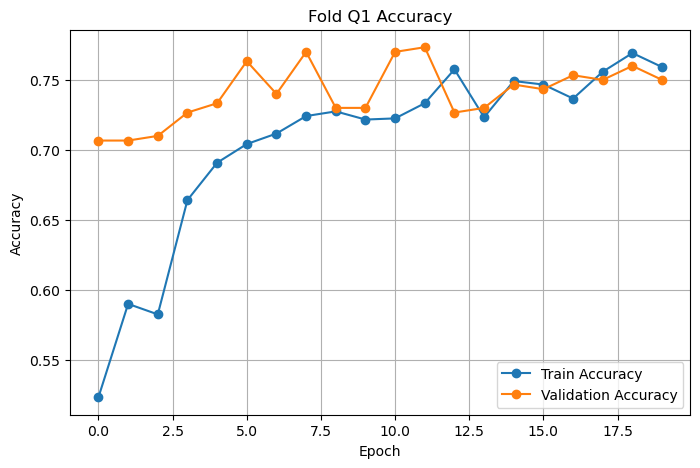

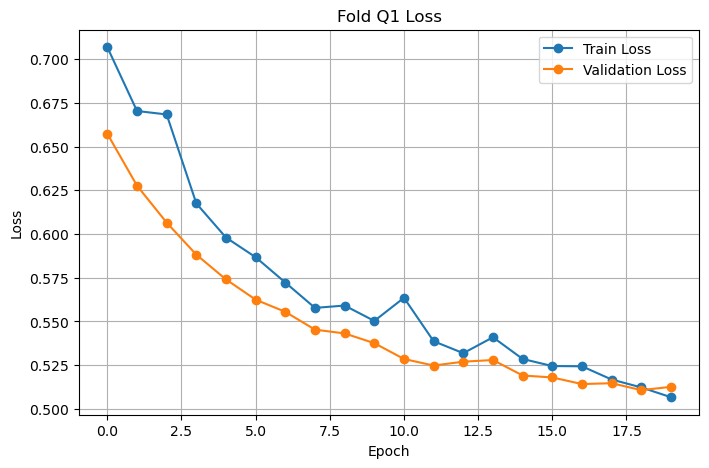

Saved model: vgg16_fold_Q1.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step


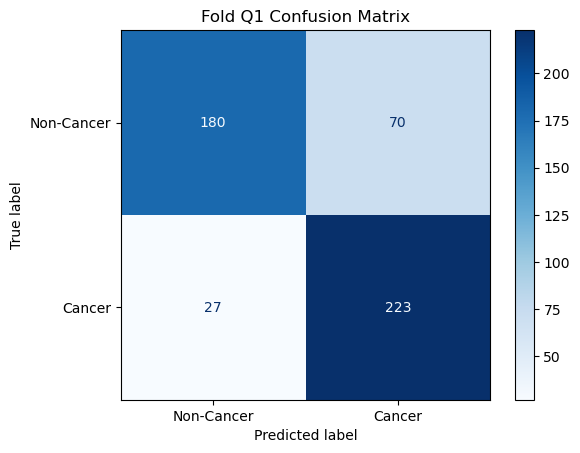

16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.8181 - loss: 0.4391
Fold Q1 Test Accuracy: 0.8060
Starting Fold: Test on Q2
Found 1200 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 217s 6s/step - accuracy: 0.5208 - loss: 0.7067 - val_accuracy: 0.6200 - val_loss: 0.6627
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 242s 6s/step - accuracy: 0.6131 - loss: 0.6638 - val_accuracy: 0.7333 - val_loss: 0.6320
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 247s 7s/step - accuracy: 0.6492 - loss: 0.6306 - val_accuracy: 0.7333 - val_loss: 0.6107
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 235s 6s/step - accuracy: 0.6997 - loss: 0.6018 - val_accuracy: 0.7400 - val_loss: 0.5952
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 215s 6s/step - accuracy: 0.7100 - loss: 0.5875 - val_accuracy: 0.7100 - val_loss: 0.5886
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 210s 6s/step - accuracy: 0.6872 - loss: 0.5943 - val_accuracy: 0.7333 - val_loss: 0.5761
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 211s 6s/step - accuracy: 0.7253 - loss: 0.5679 - val_accuracy: 0.7467 - val_loss: 0.5646
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.7145 - loss: 0.5585 - val_accuracy: 0.7367 - v

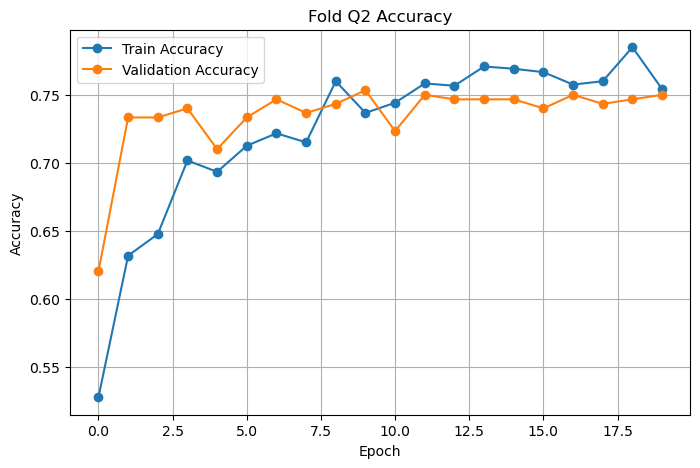

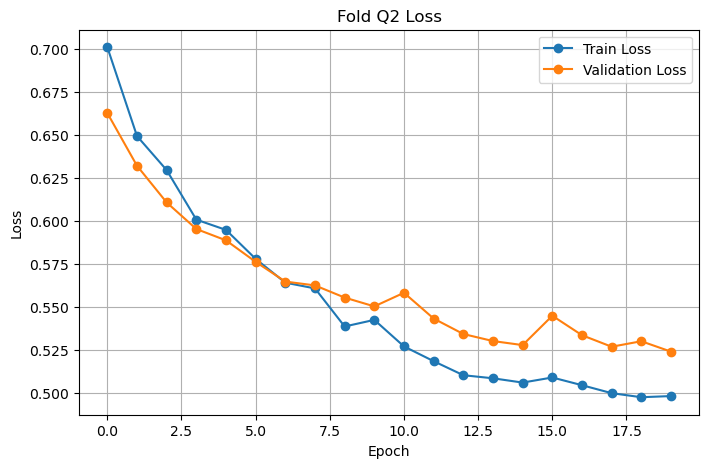

Saved model: vgg16_fold_Q2.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step


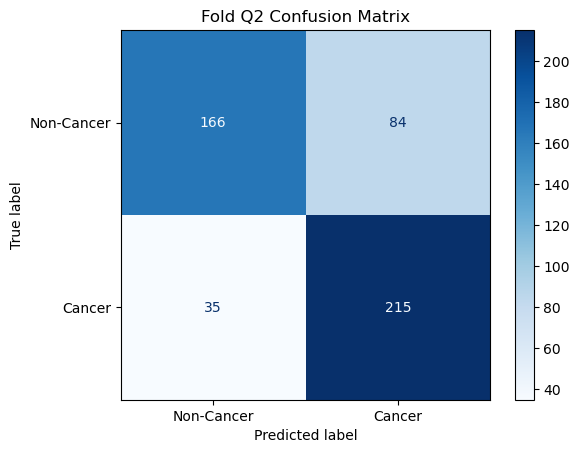

16/16 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.7745 - loss: 0.4968
Fold Q2 Test Accuracy: 0.7620
Starting Fold: Test on Q3
Found 1200 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - accuracy: 0.5124 - loss: 0.7191 - val_accuracy: 0.6733 - val_loss: 0.6520
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - accuracy: 0.6092 - loss: 0.6600 - val_accuracy: 0.7300 - val_loss: 0.6156
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.6352 - loss: 0.6252 - val_accuracy: 0.7133 - val_loss: 0.5933
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - accuracy: 0.7141 - loss: 0.5829 - val_accuracy: 0.7500 - val_loss: 0.5712
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - accuracy: 0.7168 - loss: 0.5652 - val_accuracy: 0.7600 - val_loss: 0.5519
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.7090 - loss: 0.5653 - val_accuracy: 0.7600 - val_loss: 0.5386
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.7309 - loss: 0.5465 - val_accuracy: 0.7833 - val_loss: 0.5259
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - accuracy: 0.7596 - loss: 0.5241 - val_accuracy: 0.7500 - v

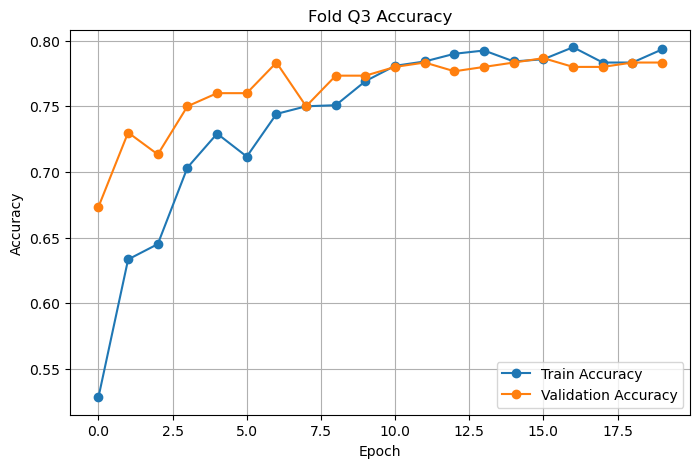

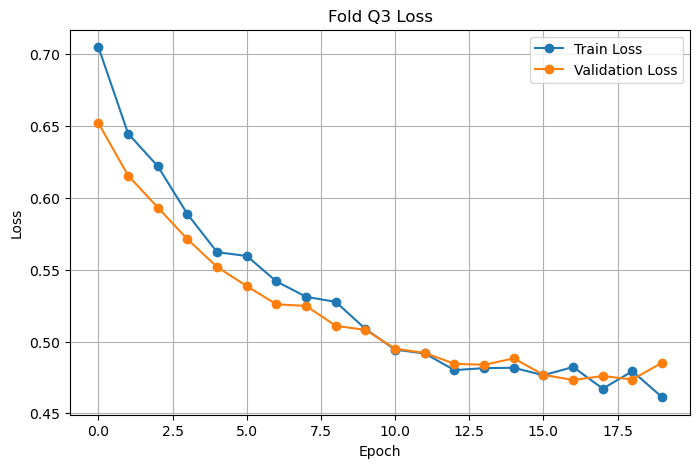

Saved model: vgg16_fold_Q3.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step


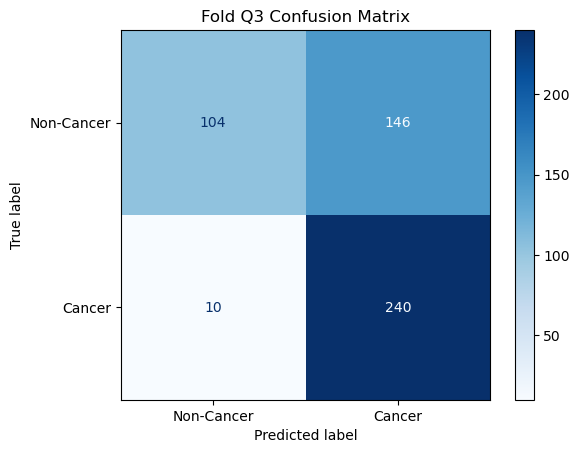

16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.7048 - loss: 0.5847
Fold Q3 Test Accuracy: 0.6880
Starting Fold: Test on Q4
Found 1200 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5423 - loss: 0.7292 - val_accuracy: 0.6567 - val_loss: 0.6647
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5754 - loss: 0.6919 - val_accuracy: 0.7000 - val_loss: 0.6349
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.5996 - loss: 0.6635 - val_accuracy: 0.7200 - val_loss: 0.6125
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 186s 5s/step - accuracy: 0.6434 - loss: 0.6279 - val_accuracy: 0.7233 - val_loss: 0.5949
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.6475 - loss: 0.6195 - val_accuracy: 0.7267 - val_loss: 0.5808
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - accuracy: 0.6782 - loss: 0.6011 - val_accuracy: 0.7300 - val_loss: 0.5693
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.6982 - loss: 0.5802 - val_accuracy: 0.7033 - val_loss: 0.5633
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - accuracy: 0.7109 - loss: 0.5687 - val_accuracy: 0.7300 - v

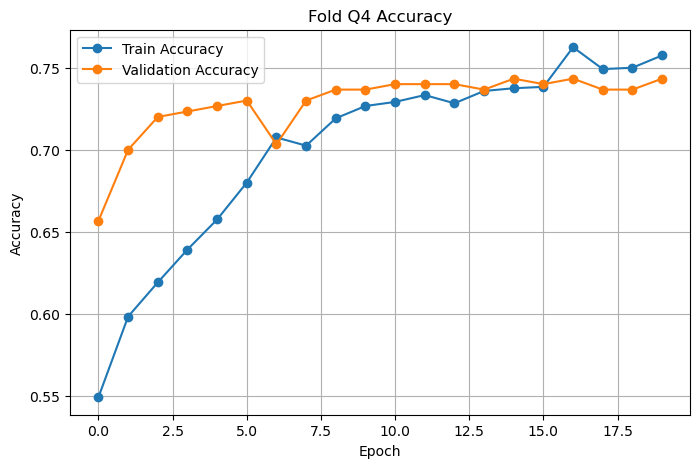

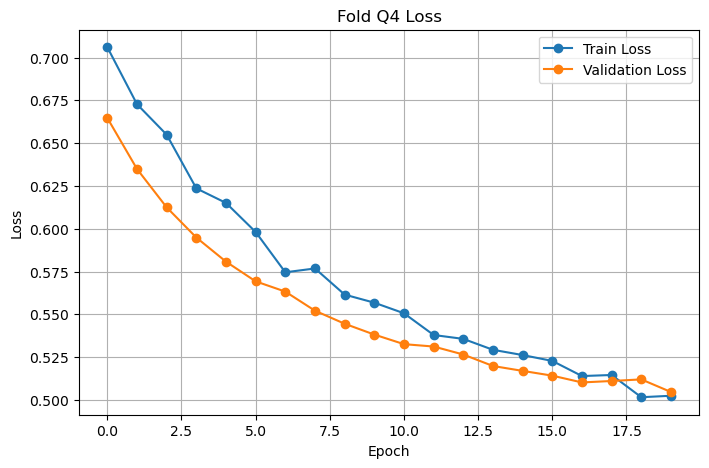

Saved model: vgg16_fold_Q4.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step


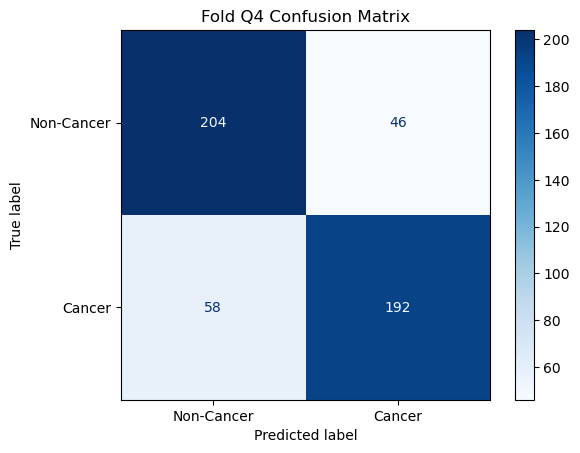

16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.7982 - loss: 0.4786
Fold Q4 Test Accuracy: 0.7920
Average 4-Fold Test Accuracy: 0.7620


In [43]:
# Set random seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# Prepare ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Store results
fold_accuracies = []

for quadrant in ["Q1", "Q2", "Q3", "Q4"]:
    print(f"Starting Fold: Test on {quadrant}")

    # Split
    test_df = df[df['Quadrant'] == quadrant]
    train_val_df = df[df['Quadrant'] != quadrant]

    # Further split train/val internally
    train_df, val_df = train_test_split(
        train_val_df, 
        test_size=0.2, 
        stratify=train_val_df['label'], 
        random_state=3888
    )

    # Data Generators
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    test_gen = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col='Path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )

    # Build Model
    model = build_vgg16_model()

    # Train
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate

    # --- Plot training curves ---
    
    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title(f'Fold {quadrant} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'Fold {quadrant} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    # --- Save model ---
    model.save(f"vgg16_fold_{quadrant}.h5")
    print(f"Saved model: vgg16_fold_{quadrant}.h5")
    
    # --- Confusion Matrix on Test Set ---
    # Get test predictions
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cancer", "Cancer"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Fold {quadrant} Confusion Matrix')
    plt.show()

    test_loss, test_acc = model.evaluate(test_gen)
    print(f"Fold {quadrant} Test Accuracy: {test_acc:.4f}")
    fold_accuracies.append(test_acc)

# Final report
mean_acc = np.mean(fold_accuracies)
print(f"Average 4-Fold Test Accuracy: {mean_acc:.4f}")


In [44]:
# insert this after confusion matrix
# from sklearn.metrics import classification_report

# # --- Predict ---
# y_true = test_gen.classes
# y_pred_probs = model.predict(test_gen)
# y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# # --- Generate classification report ---
# target_names = ["Non-Cancer", "Cancer"]

# report = classification_report(y_true, y_pred, target_names=target_names, digits=2)
# print(f"\nClassification Report for Fold {quadrant}:\n")
# print(report)

#print("Classification Report:")
#print(classification_report(y_true, y_pred, target_names=["Non-Cancer", "Cancer"]))

16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step

Classification Report for Fold Q4:

              precision    recall  f1-score   support

  Non-Cancer       0.78      0.82      0.80       250
      Cancer       0.81      0.77      0.79       250

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500

